In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 一范数损失和均方损失
$loss_{l_{1}} =\displaystyle \sum_{y\in\mathbf{\hat{y}}-\mathbf{y}} \text{abs}({y})$

逐步收敛，拟合效果一般不如MSE


$loss_{MSE} = \displaystyle \frac{1}{2} (\mathbf{\hat{y}}-\mathbf{y}) \cdot (\mathbf{\hat{y}}-\mathbf{y})$

收敛较快，拟合效果较好

In [21]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(42)
# 编点数据
x_values = np.arange(-5, 5, 0.05)
y_values = 3 * x_values
noise = np.random.normal(0, 2, len(x_values))
y_values_noisy = y_values + noise

x_train = torch.FloatTensor(x_values.reshape(-1, 1)).to(device)
y_train = torch.FloatTensor(y_values_noisy.reshape(-1, 1)).to(device)

In [22]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

In [23]:
def train_model(loss_function_name):
    model = LinearRegressionModel()
    model.to(device)
    if loss_function_name == "L1":
        criterion = nn.L1Loss()
    # elif loss_function_name == "MSE":
    else:
        criterion = nn.MSELoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    epochs = 200
    for epoch in range(epochs):
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f'{loss_function_name}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.3f}')

    return model

----------一范数损失----------
L1, Epoch [20/200], Loss: 6.223
L1, Epoch [40/200], Loss: 5.052
L1, Epoch [60/200], Loss: 3.962
L1, Epoch [80/200], Loss: 2.998
L1, Epoch [100/200], Loss: 2.237
L1, Epoch [120/200], Loss: 1.857
L1, Epoch [140/200], Loss: 1.647
L1, Epoch [160/200], Loss: 1.566
L1, Epoch [180/200], Loss: 1.544
L1, Epoch [200/200], Loss: 1.528

-----------均方损失-----------
MSE, Epoch [20/200], Loss: 3.565
MSE, Epoch [40/200], Loss: 3.464
MSE, Epoch [60/200], Loss: 3.446
MSE, Epoch [80/200], Loss: 3.438
MSE, Epoch [100/200], Loss: 3.435
MSE, Epoch [120/200], Loss: 3.433
MSE, Epoch [140/200], Loss: 3.433
MSE, Epoch [160/200], Loss: 3.432
MSE, Epoch [180/200], Loss: 3.432
MSE, Epoch [200/200], Loss: 3.432


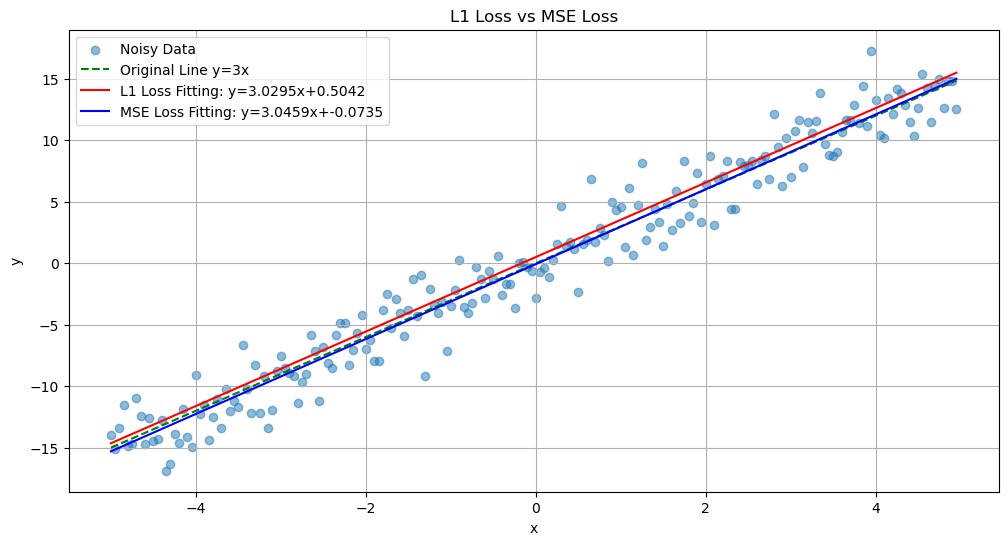

In [25]:
print("----------1范数损失----------")
l1_model = train_model("L1")

print("\n-----------均方损失-----------")
mse_model = train_model("MSE")

plt.figure(figsize=(12, 6))

plt.scatter(x_values, y_values_noisy, label='Noisy Data', alpha=0.5)
plt.plot(x_values, y_values, color='green', linestyle='--', label='Original Line y=3x')

with torch.no_grad():
    l1_predicted = l1_model(x_train).cpu().numpy()
    weight = l1_model.linear.weight.detach().cpu().numpy()[0]
    bias = l1_model.linear.bias.detach().cpu().numpy()[0]
    function_l1 = f"y={weight[0]:.4f}x+{bias:.4f}"
    plt.plot(x_values, l1_predicted, 'r', label=f'L1 Loss Fitting: {function_l1}')

with torch.no_grad():
    mse_predicted = mse_model(x_train).cpu().numpy()
    weight = mse_model.linear.weight.detach().cpu().numpy()[0]
    bias = mse_model.linear.bias.detach().cpu().numpy()[0]
    function_mse = f"y={weight[0]:.4f}x+{bias:.4f}"
    plt.plot(x_values, mse_predicted, 'b', label=f'MSE Loss Fitting: {function_mse}')

plt.title("L1 Loss and MSE Loss")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# 交叉熵损失
对于稠密连接层输出向量$\mathbf{o}，$softmax函数定义：
$\mathbf{\hat{y}} = \text{softmax}(\mathbf{o})$

$\hat{y}_{i} = \displaystyle \frac{\text{exp}(o_i)}{\displaystyle \sum_{o_j \in \mathbf{o}} \text{exp}(o_j)}$

$loss_{CrossEntropy} = -\mathbf{y}\cdot\ln{\mathbf{\hat{y}}} =\displaystyle -\sum_{i}^{\text{dim}(\mathbf{y})} y_i\ln{\hat{y}_i}$


In [ ]:
# torch.nn.CrossEntropyLoss在内部实现了求softmax
# 见resnet_cifar10_crossentropy.py

# 随机梯度下降优化器
思想是用这一个batch的数据来计算每一层参数的梯度，根据梯度对原参数做优化
$\mathbf{w}_{new} = \mathbf{w}_{old} - \alpha \mathbf{w}_{grad}$

## momentum参数（动量）
动量因子，当前的更新梯度 = momentum × 上一步的更新梯度 + 当前计算出的梯度方向。
这个操作累加了之前的所有更新操作的梯度方向，如果更新方向差别不大（梯度朝一个方向），那么模动量累计很大，型收敛很快

## nesterov参数(T/F)
这个做法按照momentum的做法，用先前的动量预估自己到达的新位置，在这个新位置算梯度，用这个新位置的梯度决定自己真正要被更新的梯度方向

这个做法更智能，防止冲劲太大冲过头

In [ ]:
# 见resnet_cifar10_crossentropy.py